### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [4]:
from inspect import getsource

In [5]:
DEBUG = True
RANDOM_STATE = 45

In [6]:
def fit_feature(df, col, cond, dry=False, suffix=''):
    df = df.copy()
    outliers = df[cond].shape[0]
    total_lines = df.shape[0]

    outlier_feature = f"{col}_{suffix}"

    if not dry and outlier_feature not in df.columns:
        df[outlier_feature] = 0

    if not dry and outliers > 0:
            df.loc[cond & (df[outlier_feature] == 0), outlier_feature] = 1
    
    if DEBUG:
        print(f"Feature: {col}, outliers: {round(100 * outliers / total_lines, 2)}%"
              f" ({outliers}/{total_lines})")
    
    return df

In [7]:
 def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train metrics",
          f"R2:\t{str(round(r2_score(train_true_values, train_pred_values), 3))}",
          f"RMSE:\t{str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3))}",
          f"MSE:\t{str(round(mse(train_true_values, train_pred_values), 3))}",
          "",
          sep='\n'
         )
    print("Test metrics",
          f"R2:\t{str(round(r2_score(test_true_values, test_pred_values), 3))}",
          f"RMSE:\t{str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3))}",
          f"MSE:\t{str(round(mse(test_true_values, test_pred_values), 3))}",
          "",
          sep='\n'
         )

    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = str(df[col].dtype)

        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()

            if col_type.startswith('int'):
                i8, i16, i32, i64 = \
                    np.iinfo(np.int8), np.iinfo(np.int16), \
                    np.iinfo(np.int32), np.iinfo(np.int64)

                if c_min >= i8.min and c_max <= i8.max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= i16.min and c_max <= i16.max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= i32.min and c_max <= i32.max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= i64.min and c_max <= i64.max:
                    df[col] = df[col].astype(np.int64)
            elif col_type.startswith('uint'):
                ui8, ui16, ui32, ui64 = \
                    np.iinfo(np.uint8), np.iinfo(np.uint16), \
                    np.iinfo(np.uint32), np.iinfo(np.uint64)

                if c_min >= ui8.min and c_max <= ui8.max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min >= ui16.min and c_max <= ui16.max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min >= ui32.min and c_max <= ui32.max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min >= ui64.min and c_max <= ui64.max:
                    df[col] = df[col].astype(np.uint64)
            elif col_type.startswith('float'):
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            else:
                # category никак не обрабатываем
                pass
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Пути к директориям и файлам

In [9]:
TRAIN_DATASET_FILE = './train.csv'
TEST_DATASET_FILE = './test.csv'

In [10]:
df_train = pd.read_csv(TRAIN_DATASET_FILE)
df_train.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995   1260          61    2.0  49.090728   33.272626            6.0      3   
9996  16265          27    2.0  64.307684   37.038420            9.0     13   
9997   2795         178    1.0  29.648057   16.555363            5.0      3   
9998  14561          21    1.0  32.330292   22.326870            5.0      3   
9999   7202          94    1.0  35.815476   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995        12.0       1981   0.300323         B         B        52   
9996         0.0       1977   0.072158         B         B         2   
9997         5.0       1958   0.460556         B         B        20   
9998         9.0       1969   0.194489         B         B        47   
9999         9.0       1975   0.127376         B         B        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995     10311         6           NaN            1        9       B   
9996       629         1           NaN            0        0       A   
9997      4386        14           NaN            1        5       B   
9998      8004         3         125.0            3        5       B   
9999      8429         3           NaN            3        9       B   

              Price  
9995  119367.455796  
9996  199715.148807  
9997  165953.912580  
9998  171842.411855  
9999  177685.627486

In [11]:
df_test = pd.read_csv(TEST_DATASET_FILE)
df_test.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   94.521465           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B

In [12]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### EDA

In [13]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
df_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [15]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [16]:
df_test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [17]:
df_test.nunique()

Id               5000
DistrictId        201
Rooms               8
Square           5000
LifeSquare       3959
KitchenSquare      38
Floor              35
HouseFloor         41
HouseYear          97
Ecology_1         130
Ecology_2           2
Ecology_3           2
Social_1           51
Social_2          143
Social_3           30
Healthcare_1       79
Helthcare_2         7
Shops_1            16
Shops_2             2
dtype: int64

In [18]:
df_test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

##### Проверка целевой переменной в тесте

In [19]:
df_train.shape[1] - df_test.shape[1]

1

In [20]:
valid_feature_types = {
    'Id': str,
    'DistrictId': str,
    'Rooms': np.uint8,
    'HouseFloor': np.uint8,
}

df_train = df_train.astype(valid_feature_types)
df_test = df_test.astype(valid_feature_types)

In [21]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.39 MB
Memory usage after optimization is: 0.83 MB
Decreased by 40.4%


In [22]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.66 MB
Memory usage after optimization is: 0.39 MB
Decreased by 40.4%


### Целевая переменная

In [23]:
X = df_train.drop('Price', axis=1)
y = df_train.Price

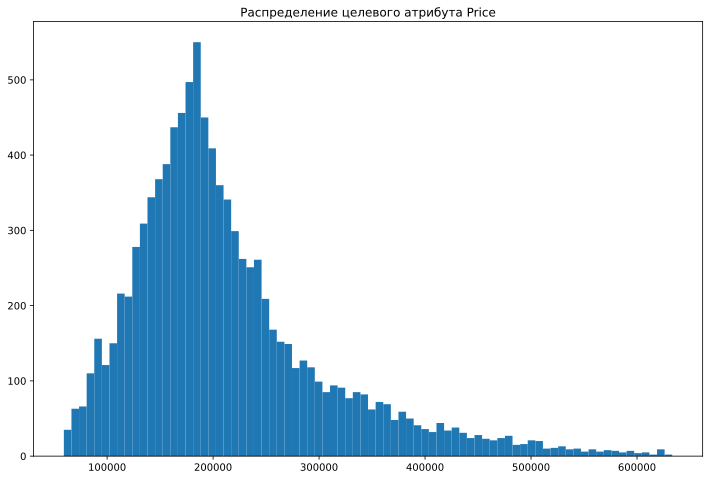

In [24]:
plt.figure(figsize=(12, 8))
df_train.Price.hist(bins=80, grid=False)
plt.title('Распределение целевого атрибута Price', pad=5)
plt.show()

#### Как видим, с распределением целевой переменной Price все нормально

### Количественные переменные/фичи

In [25]:
df_train.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315720    37.199665       6.273300      8.526700   
std        0.839512     21.058716    86.241219      28.560839      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774879    22.769833       1.000000      4.000000   
50%        2.000000     52.513309    32.781261       6.000000      7.000000   
75%        2.000000     65.900627    45.128803       9.000000     12.000000   
max       19.000000    641.065186  7480.592285    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904419      1.319500      4.231300  214138.937500  
std       23.831875   1021.519470      1.493601      4.806341   92872.273438  
min        0.000000      0.000000      0.000000      0.000000   59174.777344  
25%        0.000000    350.000000      0.000000      1.000000  153872.628906  
50%        2.000000    900.000000      1.000000      3.000000  192269.648438  
75%        5.000000   1548.000000      2.000000      6.000000  249135.460938  
max      141.000000   4849.000000      6.000000     23.000000  633233.437500

In [26]:
df_train.drop('Price', axis=1).select_dtypes(exclude='category').columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

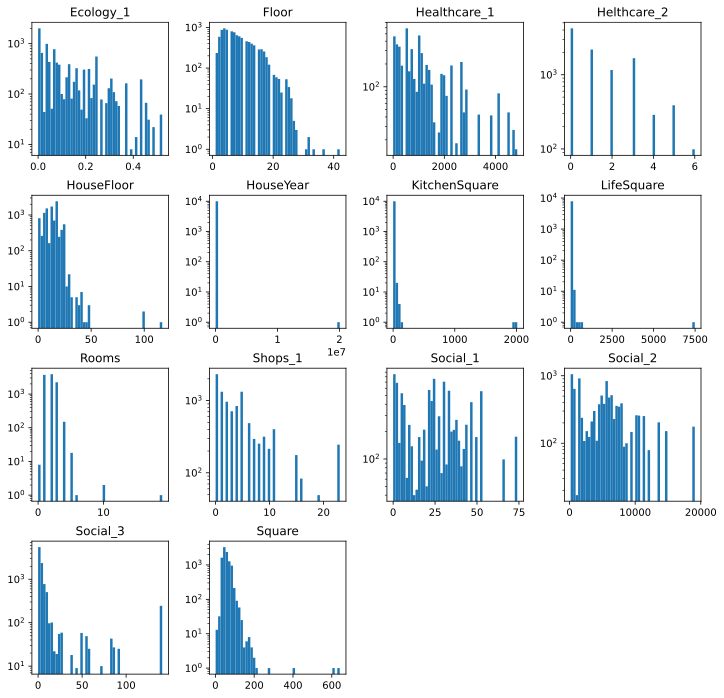

In [27]:
df_train[df_train.drop('Price', axis=1).select_dtypes(exclude='category').columns.tolist()].hist(figsize=(12,12), grid=False, bins=50, log=True)
plt.show()

### Категориальные переменные/фичи

In [28]:
df_train.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [29]:
df_train['Id'].value_counts()

9999     1
15027    1
15038    1
15037    1
15036    1
        ..
4921     1
4920     1
4918     1
4916     1
0        1
Name: Id, Length: 10000, dtype: int64

In [30]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
207      1
209      1
117      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [31]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [32]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [33]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов

### Rooms

In [34]:
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [35]:
# Из данных видно, что в выборке квартиры 1-5 комнатные. Зададим параметры для комнат:
MIN_ROOMS = 0
MAX_ROOMS = 5

In [36]:
rooms_outlier_cond = (df_train.Rooms <= MIN_ROOMS) | (df_train.Rooms > MAX_ROOMS)

In [37]:
df_train = fit_feature(df_train, 'Rooms', rooms_outlier_cond, suffix='outlier')

Feature: Rooms, outliers: 0.12% (12/10000)


In [38]:
df_train['Square'].value_counts()

37.498161    2
65.285133    2
81.867165    2
80.794792    2
44.482914    2
            ..
35.660820    1
51.660706    1
71.321365    1
81.321167    1
44.000046    1
Name: Square, Length: 9995, dtype: int64

In [39]:
# Квартира площадью меньше 22 метров и больше 190 метров считаю за выброс. Зададим параметры для комнат:
MIN_SQUARE = 22
MAX_SQUARE = 190

In [40]:
df_train['cat_Square'] = df_train.Square // 10 * 10

In [41]:

square_cond = (df_train.Square >= MIN_SQUARE) & (df_train.Square <= MAX_SQUARE)
med_rooms_by_square = df_train[~rooms_outlier_cond & square_cond]\
    .groupby('cat_Square').agg({'Rooms': 'median'}).to_dict()['Rooms']

In [42]:
df_train.loc[rooms_outlier_cond, 'Rooms'] = \
    df_train[rooms_outlier_cond].cat_Square.map(med_rooms_by_square)

In [43]:
df_train.Rooms.fillna(df_train.Rooms.median(), inplace=True)

In [44]:
df_train.Rooms.mean(), df_train.Rooms.quantile(.5), df_train.shape[0]

(1.8883, 2.0, 10000)

In [45]:
df_train['Rooms'].value_counts()

2.0    3885
1.0    3709
3.0    2238
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [46]:
square_base_cond = \
    (~df_train.Square.isna()) \
    & (~df_train.LifeSquare.isna()) \
    & (~df_train.KitchenSquare.isna())

In [47]:
df_train.Square.describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

In [48]:
square_outlier_cond = (df_train.Square < MIN_SQUARE) | (df_train.Square >= MAX_SQUARE)

In [49]:
df_train = fit_feature(df_train, 'Square', square_outlier_cond, suffix='outlier')

Feature: Square, outliers: 0.33% (33/10000)


In [50]:
med_square_by_rooms = df_train[~square_outlier_cond]\
    .groupby('Rooms').agg({'Square': 'median'}).to_dict()['Square']
med_square_by_rooms

{1.0: 40.439300537109375,
 2.0: 55.851314544677734,
 3.0: 77.44145965576172,
 4.0: 98.64940643310547,
 5.0: 113.22463989257812}

In [51]:
df_train.loc[square_outlier_cond, 'Square'] = \
    df_train[square_outlier_cond].Rooms.map(med_square_by_rooms)

In [52]:
m_test = df_train.median()
m_test.Square

52.53990936279297

In [53]:
df_train.Square.mean(), df_train.Square.quantile(.5), df_train.shape[0]

(56.195594787597656, 52.53990936279297, 10000)

In [54]:
df_train.quantile(.025)

Rooms                 1.000000
Square               32.330151
LifeSquare            5.914130
KitchenSquare         0.000000
Floor                 2.000000
HouseFloor            0.000000
HouseYear          1959.000000
Ecology_1             0.000000
Social_1              1.000000
Social_2            264.000000
Social_3              0.000000
Healthcare_1         30.000000
Helthcare_2           0.000000
Shops_1               0.000000
Price             87244.382812
Rooms_outlier         0.000000
cat_Square           30.000000
Square_outlier        0.000000
Name: 0.025, dtype: float64

In [55]:
df_train.Square.value_counts()

40.439301    19
55.851315     7
77.441460     6
98.649406     2
37.498161     2
             ..
71.321365     1
81.321167     1
42.660480     1
45.581394     1
44.000046     1
Name: Square, Length: 9964, dtype: int64

### LifeSquare

In [56]:
df_train.LifeSquare.describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [57]:
df_train.LifeSquare.quantile(.025), df_train.LifeSquare.quantile(.975)

(5.9141297, 80.7481)

In [58]:
(df_train.LifeSquare // 10 * 10).value_counts()

20.0      2202
30.0      2074
40.0      1505
10.0       711
50.0       509
60.0       313
0.0        205
70.0       158
80.0       111
90.0        37
100.0       24
110.0       10
120.0        9
130.0        4
160.0        4
170.0        2
210.0        1
460.0        1
150.0        1
410.0        1
630.0        1
260.0        1
230.0        1
200.0        1
7480.0       1
Name: LifeSquare, dtype: int64

In [59]:
lsquare_outlier_lq_cond = (df_train.LifeSquare < df_train.LifeSquare.quantile(.025))
df_train = fit_feature(df_train, 'LifeSquare', lsquare_outlier_lq_cond, suffix='outlier')

Feature: LifeSquare, outliers: 1.98% (198/10000)


#### Как видим выбросы есть, попробуем исправить

In [60]:
lsquares_outlier_cond = df_train.LifeSquare > (df_train.Square - 5)
df_train = fit_feature(df_train, 'LifeSquare', lsquares_outlier_cond, suffix='outlier')

Feature: LifeSquare, outliers: 11.6% (1160/10000)


In [61]:
lsquare_valid_cond = \
    ~lsquares_outlier_cond \
    & (df_train.Rooms_outlier == 0) \
    & (df_train.Square_outlier == 0) \
    & (df_train.LifeSquare_outlier == 0) \
    & (~df_train.Square.isna()) \
    & (~df_train.LifeSquare.isna()) \
    & (~df_train.KitchenSquare.isna())

include_columns = [
    'Rooms',
    'Square',
    'LifeSquare',
]

df_lsquare = df_train.loc[lsquare_valid_cond, include_columns]
df_lsquare.shape

(6512, 3)

In [62]:
ls_X_train, ls_X_test, ls_y_train, ls_y_test = train_test_split(
    df_lsquare.drop(columns=['LifeSquare']),
    df_lsquare.LifeSquare,
    test_size=.3,
    random_state=RANDOM_STATE
)

In [63]:
ls_lr_model = LinearRegression(normalize=True)
ls_fit_lr_model = ls_lr_model.fit(ls_X_train, ls_y_train)

Train metrics
R2:	0.872
RMSE:	4.401
MSE:	19.37

Test metrics
R2:	0.882
RMSE:	4.231
MSE:	17.902



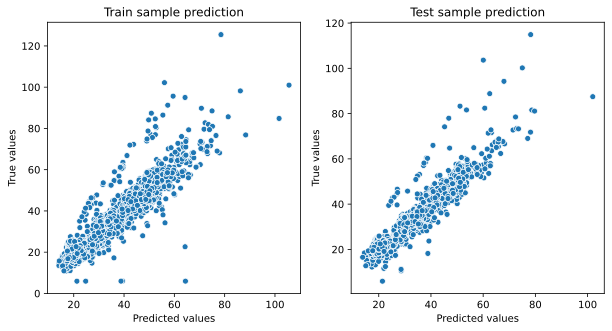

In [64]:
evaluate_preds(
    ls_y_train, ls_fit_lr_model.predict(ls_X_train),
    ls_y_test, ls_fit_lr_model.predict(ls_X_test),
)

Train metrics
R2:	0.942
RMSE:	2.953
MSE:	8.721

Test metrics
R2:	0.89
RMSE:	4.091
MSE:	16.739



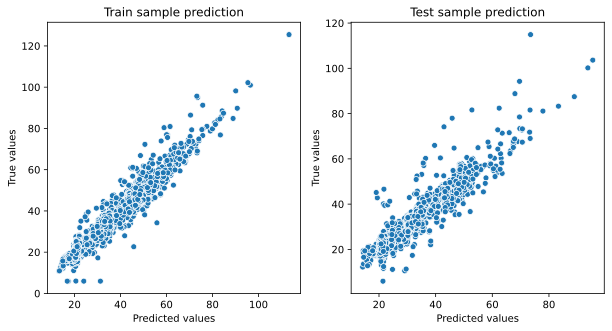

In [65]:
# Случайный лес
# Долго подбирал параметры но эти вроде прижились лучше чем линейная регрессия
ls_rf_model = RandomForestRegressor(
    n_estimators=90,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
ls_fit_rf_model = ls_rf_model.fit(ls_X_train, ls_y_train)

evaluate_preds(
    ls_y_train, ls_fit_rf_model.predict(ls_X_train),
    ls_y_test, ls_fit_rf_model.predict(ls_X_test),
)

In [66]:
lsquare_outlier_dataset = df_train.loc[
    lsquares_outlier_cond,
    include_columns
]

In [67]:
df_train.loc[lsquares_outlier_cond, 'LifeSquare'] = \
    ls_fit_rf_model.predict(lsquare_outlier_dataset.drop(columns=['LifeSquare']))

In [68]:
_ = fit_feature(
    df_train,
    'LifeSquare',
    df_train.LifeSquare > (df_train.Square - 5),
    dry=True
)

Feature: LifeSquare, outliers: 0.0% (0/10000)


In [69]:
df_train.LifeSquare.mean(), \
df_train.LifeSquare.quantile(.5), \
df_train.shape[0]

(32.30078125, 31.140215, 10000)

### KitchenSquare


In [70]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [71]:
df_train.KitchenSquare.describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

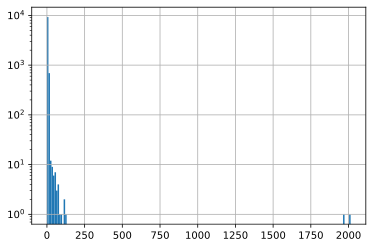

In [72]:
df_train.KitchenSquare.hist(log=True, bins=200)

In [73]:
df_train = fit_feature(df_train, 'KitchenSquare', df_train.KitchenSquare > 150, suffix='outlier')

Feature: KitchenSquare, outliers: 0.02% (2/10000)


In [74]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [75]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [76]:
condition_fitchen_sq = (df_train['KitchenSquare'].isna()) \
             | (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975))
        
df_train.loc[condition_fitchen_sq, 'KitchenSquare'] = df_train['KitchenSquare'].median()

df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [77]:
df_train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

### Floor

In [78]:
df_train.Floor.describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [79]:
df_train.Floor.value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
33      1
37      1
31      1
Name: Floor, dtype: int64

In [80]:
df_train = fit_feature(
    df_train, 
    'Floor', 
    df_train.Floor > df_train.HouseFloor, 
    suffix='outlier'
)

Feature: Floor, outliers: 18.25% (1825/10000)


In [81]:
df_train.Floor.max(), \
df_train.Floor.mean(), \
df_train.Floor.quantile(.5), \
df_train.shape[0]

(42, 8.5267, 7.0, 10000)

In [82]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [83]:
df_train['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=uint8)

### HouseFloor

In [84]:
df_train.HouseFloor.describe() 

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [85]:
df_train.HouseFloor.value_counts() 

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
26        1
36        1
44        1
38        1
29        1
117       1
31        1
45        1
47        1
Name: HouseFloor, dtype: int64

In [86]:
 housefloor_outliers_cond = (df_train.HouseFloor > 50) | (df_train.HouseFloor <= 0)
df_train = fit_feature(
    df_train,
    'HouseFloor',
    housefloor_outliers_cond,
    suffix='outlier'
)

Feature: HouseFloor, outliers: 2.72% (272/10000)


In [87]:
df_train = fit_feature(
    df_train,
    'HouseFloor',
    housefloor_outliers_cond,
    suffix='outlier'
)

Feature: HouseFloor, outliers: 2.72% (272/10000)


In [88]:
df_train.loc[housefloor_outliers_cond, 'HouseFloor'] = df_train.HouseFloor.median()

In [89]:
df_train.HouseFloor.mean(), \
df_train.HouseFloor.quantile(.5), \
df_train.shape[0]

(12.9315, 13.0, 10000)

In [90]:
df_train.Floor.mean(), \
df_train.Floor.quantile(.5), \
df_train.shape[0]

(8.5267, 7.0, 10000)

### HouseYear

In [91]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [92]:
df_train.HouseYear.median()

1977.0

In [93]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2020

In [94]:
df_train['HouseYear'].sort_values(ascending=False)

7246    2020
2350    2020
8296    2020
3171    2020
3196    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int32

In [95]:
df_train.HouseYear.mean(), \
df_train.HouseYear.quantile(.5), \
df_train.shape[0]

(1984.8724, 1977.0, 10000)

### Ecology_1

In [96]:
df_train.Ecology_1.describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

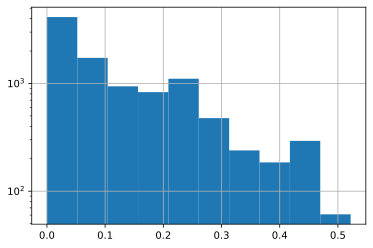

In [97]:
df_train.Ecology_1.hist(log=True)

In [98]:
df_train.Ecology_1.mean(), \
df_train.Ecology_1.quantile(.5), \
df_train.shape[0]

(0.11885839700698853, 0.07542368024587631, 10000)

### Social_1

In [99]:
df_train.Social_1.describe()

count    10000.000000
mean        24.687000
std         17.532614
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

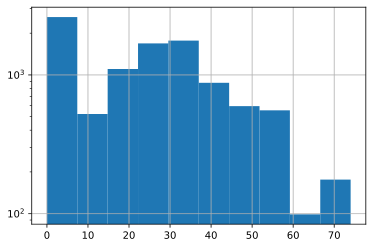

In [100]:
df_train.Social_1.hist(log=True)

In [101]:
df_train.Social_1.quantile(.025), df_train.Social_1.quantile(.975)

(1.0, 66.0)

In [102]:
df_train.Social_1.mean(), \
df_train.Social_1.quantile(.5), \
df_train.shape[0]

(24.687, 25.0, 10000)

### Social_2

In [103]:
df_train.Social_2.describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

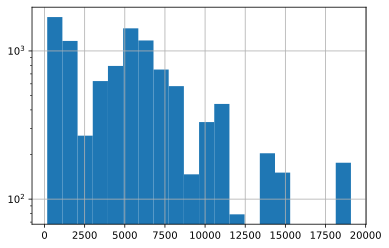

In [104]:
df_train.Social_2.hist(log=True, bins=20)

In [105]:
df_train.Social_2.mean(), \
df_train.Social_2.quantile(.5), \
df_train.shape[0]

(5352.1574, 5285.0, 10000)

In [106]:
social2_outlier_cond = \
    (df_train.Social_2 < df_train.Social_2.quantile(.025)) \
    | (df_train.Social_2 > df_train.Social_2.quantile(.975))
df_train = fit_feature(df_train, 'Social_2', social2_outlier_cond, suffix='outlier')

Feature: Social_2, outliers: 3.77% (377/10000)


In [107]:
df_train.loc[social2_outlier_cond, 'Social_2'] = df_train.Social_2.median()

In [108]:
df_train.Social_2.mean(), \
df_train.Social_2.quantile(.5), \
df_train.shape[0]

(5212.1445, 5285.0, 10000)

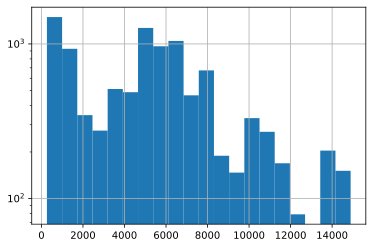

In [109]:
df_train.Social_2.hist(log=True, bins=20)

### Social_3

In [110]:
df_train.Social_3.describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

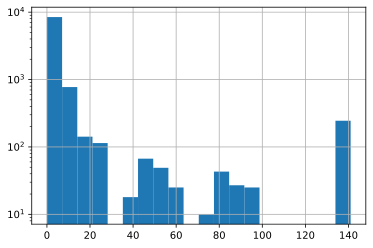

In [111]:
df_train.Social_3.hist(log=True, bins=20)

In [112]:
social3_outlier_cond = \
    (df_train.Social_3 < df_train.Social_3.quantile(.025)) \
    | (df_train.Social_3 > df_train.Social_3.quantile(.975))
df_train = fit_feature(df_train, 'Social_3', social3_outlier_cond, suffix='outlier')

Feature: Social_3, outliers: 2.45% (245/10000)


In [113]:
df_train.loc[social3_outlier_cond, 'Social_3'] = df_train.Social_3.median()

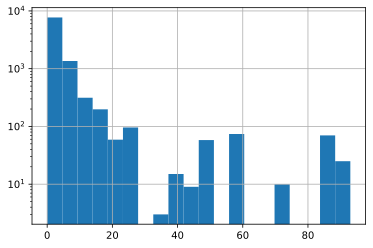

In [114]:
df_train.Social_3.hist(log=True, bins=20)

### Healthcare_1


In [115]:
df_train.Healthcare_1.describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

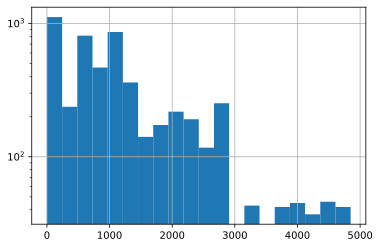

In [116]:
df_train.Healthcare_1.hist(log=True, bins=20)

### Helthcare_2

In [117]:
df_train.Helthcare_2.describe()

count    10000.000000
mean         1.319500
std          1.493601
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: Helthcare_2, dtype: float64

In [118]:
df_train.Helthcare_2.value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

### Shops_1

In [119]:
df_train.Shops_1.describe()

count    10000.000000
mean         4.231300
std          4.806341
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         23.000000
Name: Shops_1, dtype: float64

In [120]:
df_train.Shops_1.value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

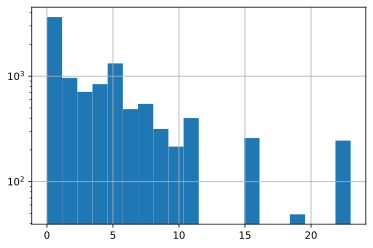

In [121]:
df_train.Shops_1.hist(log=True, bins=20)


## Обработка пропусков

In [122]:
df_train.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
cat_Square                  0
Square_outlier              0
LifeSquare_outlier          0
KitchenSquare_outlier       0
Floor_outlier               0
HouseFloor_outlier          0
Social_2_outlier            0
Social_3_outlier            0
dtype: int64

### LifeSquare (2113 пропуск)

In [123]:
lsquare_nan_cond = df_train.LifeSquare.isna()

lsquare_include_nan_columns = [
    'Rooms',       
    'Square',      
    'LifeSquare',  
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_1',
    'Social_1',
    'Social_2',
    'Social_3',
    'Shops_1',
]

In [124]:
df_train = fit_feature(df_train, 'LifeSquare', lsquare_nan_cond, suffix='nan')

Feature: LifeSquare, outliers: 21.13% (2113/10000)


In [125]:
df_nan_lsquare = df_train.loc[~lsquare_nan_cond, lsquare_include_nan_columns]

In [126]:
X_ls_nan_train, X_ls_nan_test, y_ls_nan_train, y_ls_nan_test = train_test_split(
    df_nan_lsquare.drop(columns=['LifeSquare']),
    df_nan_lsquare.LifeSquare,
    test_size=.3,
    random_state=RANDOM_STATE,
    shuffle=True,
)

Train metrics
R2:	0.801
RMSE:	5.889
MSE:	34.675

Test metrics
R2:	0.772
RMSE:	6.364
MSE:	40.501



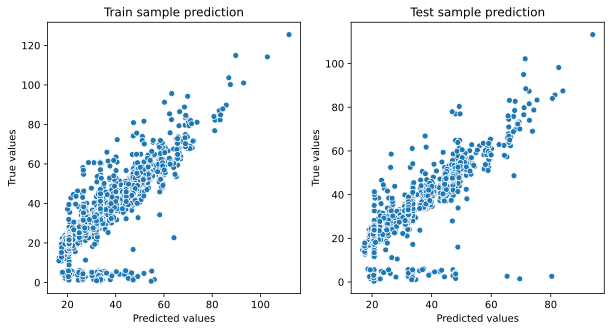

In [127]:
rf_nan_model = RandomForestRegressor(
    n_estimators=60,
    max_depth=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
fitted_rf_nan_model = rf_nan_model.fit(X_ls_nan_train, y_ls_nan_train)

evaluate_preds(
    y_ls_nan_train, fitted_rf_nan_model.predict(X_ls_nan_train),
    y_ls_nan_test, fitted_rf_nan_model.predict(X_ls_nan_test),
)

9-60 = 0.787
5-90 = 0.788
5-80 = 0.789
5-60 = 0.788

Пробуем линейную регрессию:



Train metrics
R2:	0.751
RMSE:	6.573
MSE:	43.201

Test metrics
R2:	0.769
RMSE:	6.409
MSE:	41.071



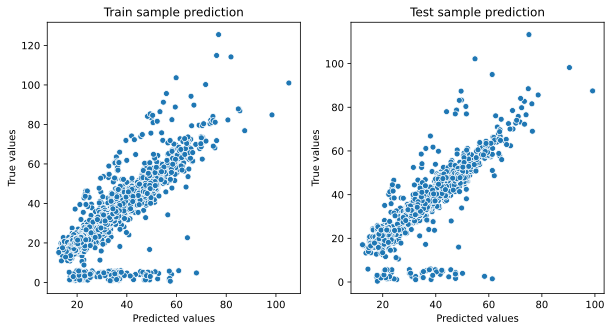

In [128]:
lr_nan_model = LinearRegression(normalize=True)
fitted_lr_nan_model = lr_nan_model.fit(X_ls_nan_train, y_ls_nan_train)

evaluate_preds(
    y_ls_nan_train, fitted_lr_nan_model.predict(X_ls_nan_train),
    y_ls_nan_test, fitted_lr_nan_model.predict(X_ls_nan_test),
)

Возмем данные ЛР для исправления пропусков

In [129]:
lifesquare_nan_dataset = df_train.loc[
    lsquare_nan_cond,
    lsquare_include_nan_columns
]

In [130]:
df_train.loc[lsquare_nan_cond, 'LifeSquare'] = \
    fitted_lr_nan_model.predict(
        lifesquare_nan_dataset.drop(columns=['LifeSquare'])
    ).reshape(-1, 1)

In [131]:
df_train.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare                  0
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
cat_Square                  0
Square_outlier              0
LifeSquare_outlier          0
KitchenSquare_outlier       0
Floor_outlier               0
HouseFloor_outlier          0
Social_2_outlier            0
Social_3_outlier            0
LifeSquare_nan              0
dtype: int64

### Healthcare_1

In [132]:
hc1_nan_pred_cond = df_train.Healthcare_1.isna()
df_train = fit_feature(df_train, 'Healthcare_1', hc1_nan_pred_cond, suffix='nan')

Feature: Healthcare_1, outliers: 47.98% (4798/10000)


In [133]:
hc1_nan_pred_features = [
    'Square',
    'LifeSquare',
    'HouseFloor',
    'HouseYear',
    'Ecology_1',
    'Social_3',
    'Healthcare_1',
    'Helthcare_2',
    'Shops_1',
    'Price',
]
hc1_nan_pred_df = df_train.loc[~hc1_nan_pred_cond, hc1_nan_pred_features]

Train metrics
R2:	0.166
RMSE:	927.327
MSE:	859936.234

Test metrics
R2:	0.142
RMSE:	958.928
MSE:	919543.803



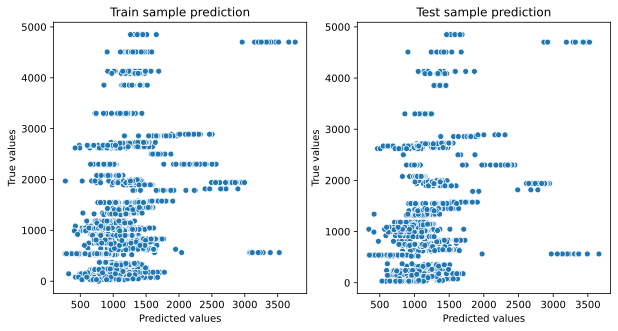

In [134]:
X_hc1_nan_train, X_hc1_nan_test, y_hc1_nan_train, y_hc1_nan_test = train_test_split(
    hc1_nan_pred_df.drop(columns='Healthcare_1'),
    hc1_nan_pred_df.Healthcare_1,
    test_size=.3,
    random_state=RANDOM_STATE,
)

hc1_nan_lr = LinearRegression(normalize=True)
hc1_nan_lr_model = hc1_nan_lr.fit(X_hc1_nan_train, y_hc1_nan_train)

# r2_score(y_pred=hc1_nan_lr_model.predict(X_hc1_nan_test), y_true=y_hc1_nan_test)
evaluate_preds(
    y_hc1_nan_train, hc1_nan_lr_model.predict(X_hc1_nan_train),
    y_hc1_nan_test, hc1_nan_lr_model.predict(X_hc1_nan_test),
)

Train metrics
R2:	1.0
RMSE:	8.231
MSE:	67.746

Test metrics
R2:	1.0
RMSE:	15.784
MSE:	249.139



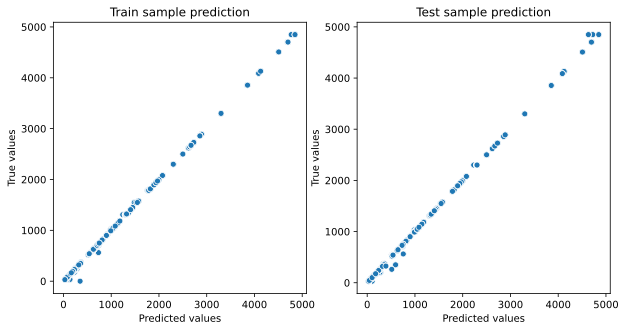

In [135]:
hc1_nan_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=17,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
hc1_nan_rf_model = hc1_nan_rf.fit(X_hc1_nan_train, y_hc1_nan_train)
# r2_score(y_true=y_hc1_nan_test, y_pred=hc1_nan_rf_model.predict(X_hc1_nan_test))
evaluate_preds(
    y_hc1_nan_train, hc1_nan_rf_model.predict(X_hc1_nan_train),
    y_hc1_nan_test, hc1_nan_rf_model.predict(X_hc1_nan_test),
)

In [136]:
hc1_nan_dataset = df_train.loc[
    hc1_nan_pred_cond,
    hc1_nan_pred_features,
]

In [137]:
df_train.loc[hc1_nan_pred_cond, 'Healthcare_1'] = \
    hc1_nan_rf_model.predict(
        hc1_nan_dataset.drop(columns=['Healthcare_1'])
    ).reshape(-1, 1)

In [138]:
#  заменил пропуски данными модели случайного леса, проверяем
df_train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
cat_Square               0
Square_outlier           0
LifeSquare_outlier       0
KitchenSquare_outlier    0
Floor_outlier            0
HouseFloor_outlier       0
Social_2_outlier         0
Social_3_outlier         0
LifeSquare_nan           0
Healthcare_1_nan         0
dtype: int64

#### Оформляем все в функции

In [139]:
def _mark_feature(X, feature, cond, suffix):
    X = X.copy()
    outliers = X[cond].shape[0]
    total_lines = X.shape[0]

    outlier_feature = f"{feature}_{suffix}"

    if outlier_feature not in X.columns:
        X[outlier_feature] = 0

    if outliers > 0:
        X.loc[cond & (X[outlier_feature] == 0), outlier_feature] = 1

    return X



class DataPreprocessing:
    MIN_ROOMS = 0
    MAX_ROOMS = 5
    MIN_SQUARE = 22
    MAX_SQUARE = 190

    def __init__(self):
        self.medians = None
        self.quantiles_025 = None
        self.quantiles_975 = None
        self.real_feature_names = None
        self.valid_feature_types = None

    @staticmethod
    def outlier_mark_feature(X, feature, cond):
        return _mark_feature(X, feature, cond, 'outlier')

    @staticmethod
    def nan_mark_feature(X, feature, cond):
        return _mark_feature(X, feature, cond, 'nan')

    def fit(self, X: pd.DataFrame):
        self.medians = X.median()
        self.quantiles_025 = X.quantile(.025)
        self.quantiles_975 = X.quantile(.975)
        self.real_feature_names = X.drop('Price', axis=1, errors='ignore').\
            select_dtypes(exclude=['category', 'object']).columns.tolist()
        self.valid_feature_types = {
            'Id': str,
            'DistrictId': str,
            'Rooms': np.uint8,
            'HouseFloor': np.uint8,
        }



    def transform(self, X: pd.DataFrame):
        X = X.copy()

        X = X.astype(self.valid_feature_types)

        # Rooms
        rooms_outlier_cond = (X.Rooms <= self.MIN_ROOMS) | (X.Rooms > self.MAX_ROOMS)
        X = self.outlier_mark_feature(X, 'Rooms', rooms_outlier_cond)

        X['cat_Square'] = X.Square // 10 * 10
        square_cond = (X.Square >= self.MIN_SQUARE) & (X.Square <= self.MAX_SQUARE)
        med_rooms_map = X[~rooms_outlier_cond & square_cond] \
            .groupby('cat_Square').agg({'Rooms': 'median'}).to_dict()['Rooms']

        X.loc[rooms_outlier_cond, 'Rooms'] = \
            X[rooms_outlier_cond].cat_Square.map(med_rooms_map)

        X.Rooms.fillna(self.medians.Rooms, inplace=True)

        # Square
        square_outlier_cond = (X.Square < self.MIN_SQUARE) | (X.Square >= self.MAX_SQUARE)
        X = self.outlier_mark_feature(X, 'Square', square_outlier_cond)

        med_square_map = X[~square_outlier_cond] \
            .groupby('Rooms').agg({'Square': 'median'}).to_dict()['Square']

        X.loc[square_outlier_cond, 'Square'] = \
            X[square_outlier_cond].Rooms.map(med_square_map)

        X.Square.fillna(self.medians.Rooms, inplace=True)

        # LifeSquare

        ls_lt_q025_outlier_cond = (X.LifeSquare < self.quantiles_025.LifeSquare)
        X = self.outlier_mark_feature(X, 'LifeSquare', ls_lt_q025_outlier_cond)
        X.loc[ls_lt_q025_outlier_cond, 'LifeSquare'] = self.quantiles_025.LifeSquare


        ls_gt_outlier_cond = X.LifeSquare > (X.Square - 5)
        X = self.outlier_mark_feature(X, 'LifeSquare', ls_gt_outlier_cond)

        lsquare_valid_cond = \
            ~ls_gt_outlier_cond \
            & (X.Rooms_outlier == 0) \
            & (X.Square_outlier == 0) \
            & (X.LifeSquare_outlier == 0) \
            & (~X.Square.isna()) \
            & (~X.LifeSquare.isna())

        ls_outlier_df = X.loc[lsquare_valid_cond, ['Rooms', 'Square', 'LifeSquare']]


        rf_model = RandomForestRegressor(
            n_estimators=90,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        ls_rf_model = rf_model.fit(
            ls_outlier_df.drop(columns=['LifeSquare']),
            ls_outlier_df.LifeSquare
        )
        X.loc[ls_gt_outlier_cond, 'LifeSquare'] = \
            ls_rf_model.predict(X.loc[ls_gt_outlier_cond, ['Rooms', 'Square']])

        X.loc[X.LifeSquare > (X.Square - 5), 'LifeSquare'] = self.medians.LifeSquare

        # Floor
        floor_gt_hfloors_outlier_cond = X.Floor > X.HouseFloor
        X = self.outlier_mark_feature(X, 'Floor', floor_gt_hfloors_outlier_cond)
        X.loc[floor_gt_hfloors_outlier_cond, ['Floor', 'HouseFloor']] = \
            X.loc[floor_gt_hfloors_outlier_cond, ['HouseFloor', 'Floor']].values

        # HouseFloor
        # (X.HouseFloor <= 0) | (X.HouseFloor > 50) cases
        hfloor_outliers_cond = (X.HouseFloor <= 0) | (X.HouseFloor > 50)
        X = self.outlier_mark_feature(X, 'HouseFloor', hfloor_outliers_cond)
        X.loc[hfloor_outliers_cond, 'HouseFloor'] = self.medians.HouseFloor

        # HouseYear
        hyear_outlier_cond = X.HouseYear > 2020
        X = self.outlier_mark_feature(X, 'HouseYear', hyear_outlier_cond)
        X.loc[hyear_outlier_cond, 'HouseYear'] = self.medians.HouseYear

        # Ecology_1
        eco1_outlier_cond = \
            (X.Ecology_1 < self.quantiles_025.Ecology_1) \
            | (X.Ecology_1 > self.quantiles_975.Ecology_1)
        X = self.outlier_mark_feature(X, 'Ecology_1', eco1_outlier_cond)

        # Social_i
        for i in (1, 2, 3):
            social_outlier_cond = \
                (X[f'Social_{i}'] < self.quantiles_025[f'Social_{i}']) \
                | (X[f'Social_{i}'] > self.quantiles_975[f'Social_{i}'])

            X = self.outlier_mark_feature(X, f'Social_{i}', social_outlier_cond)

        # Обработка пропусков

        ls_nan_pred_cond = X.LifeSquare.isna()

        ls_nan_pred_features = [
            'Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear',
            'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1',
        ]

        X = self.nan_mark_feature(X, 'LifeSquare', ls_nan_pred_cond)

        lr_model = LinearRegression(normalize=True)

        ls_lr_nan_model = lr_model.fit(
            X.loc[~ls_nan_pred_cond, ls_nan_pred_features],
            X[~ls_nan_pred_cond].LifeSquare
        )
        X.loc[ls_nan_pred_cond, 'LifeSquare'] = \
            ls_lr_nan_model.predict(
                X.loc[ls_nan_pred_cond, ls_nan_pred_features]
            ).reshape(-1, 1)

        # Healthcare_1
        hc1_nan_pred_cond = X.Healthcare_1.isna()

        X = self.nan_mark_feature(X, 'Healthcare_1', hc1_nan_pred_cond)

        hc1_nan_pred_features = [
            'Square', 'LifeSquare', 'HouseFloor', 'HouseYear',
            'Ecology_1', 'Social_3', 'Helthcare_2', 'Shops_1',
        ]

        rf_model = RandomForestRegressor(
            n_estimators=90,
            max_depth=9,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        hc1_nan_rf_model = rf_model.fit(
            X.loc[~hc1_nan_pred_cond, hc1_nan_pred_features],
            X[~hc1_nan_pred_cond].Healthcare_1,
        )

        X.loc[hc1_nan_pred_cond, 'Healthcare_1'] = \
            hc1_nan_rf_model.predict(
                X.loc[hc1_nan_pred_cond, hc1_nan_pred_features],
            ).reshape(-1, 1)
    
        X.fillna(self.medians, inplace=True)
        
        return X
  

## Генрация новых признаков


#### Dummies

In [140]:
binary_to_numbers = {'A': 0, 'B': 1}
df_train['Ecology_2'] = df_train['Ecology_2'].map(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].map(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].map(binary_to_numbers)

In [141]:
DISTRICT_POPULARITY_MAPPER = {
    'DistrictId': 'district_sale_popularity',
    'index': 'DistrictId',
}

district_sale_popularity = df_train.groupby('DistrictId').\
    agg({'DistrictId': 'count'}).rename(columns=DISTRICT_POPULARITY_MAPPER)

df_train = df_train.merge(district_sale_popularity, how='left', on='DistrictId')
df_train.district_sale_popularity.fillna(-1, inplace=True)

In [142]:
DISTRICT_PRICE_MAPPER = {'Price': 'mean_district_price'}

mean_district_price = df_train.groupby('DistrictId', as_index=False).\
    agg({'Price': 'mean'}).rename(columns=DISTRICT_PRICE_MAPPER)

df_train = df_train.merge(mean_district_price, how='left', on='DistrictId')
df_train.mean_district_price.fillna(-1, inplace=True)

In [143]:
class FeatureGenetator:
    """Генерация новых фич"""
    DUMMY_FEATURES = ['Ecology_2', 'Ecology_3', 'Shops_2']

    CTN_MAPPER = {
        'A': 0,
        'B': 1,
    }

    DISTRICT_POPULARITY_MAPPER = {
        'DistrictId': 'district_sale_popularity',
        'index': 'DistrictId',
    }

    DISTRICT_PRICE_MAPPER = {
        'Price': 'mean_district_price',
    }

    def __init__(self):
        self.district_sale_popularity = None
        self.mean_district_price = None
        self.price_per_room = None
        self.price_per_square = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        self.district_sale_popularity = \
            X.DistrictId.value_counts().reset_index().rename(columns=self.DISTRICT_POPULARITY_MAPPER)

        if y is not None:
            X['Price'] = y.values
            
            self.mean_district_price = \
                X.groupby('DistrictId', as_index=False).agg({'Price': 'mean'}).\
                rename(columns=self.DISTRICT_PRICE_MAPPER)
            
            
            
    def transform(self, X):
        X = X.copy()
        df = X[['DistrictId']]
        
        for f in self.DUMMY_FEATURES:
            X[f] = X[f].map(self.CTN_MAPPER)

        X = X.merge(self.district_sale_popularity, how='left', on='DistrictId')
        X.district_sale_popularity.fillna(-1, inplace=True)
        
        if self.mean_district_price is not None:
            X = X.merge(self.mean_district_price, how='left', on='DistrictId')
            X['mean_district_price'].fillna(-1, inplace=True)
        
        if self.price_per_room is not None:
            X['price_per_room'] = self.price_per_room

        if self.price_per_square is not None:
            X['price_per_square'] = self.price_per_square
        
        return X

### Отбор признаков

In [144]:
df_train.columns.tolist() 

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'cat_Square',
 'Square_outlier',
 'LifeSquare_outlier',
 'KitchenSquare_outlier',
 'Floor_outlier',
 'HouseFloor_outlier',
 'Social_2_outlier',
 'Social_3_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'district_sale_popularity',
 'mean_district_price']

In [145]:
orig_features = ['Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
                 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_features = ['Rooms_outlier', 'cat_Square', 'Square_outlier', 'LifeSquare_outlier',
                'Floor_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
                'Ecology_1_outlier', 'Social_1_outlier', 'Social_2_outlier',
                'Social_3_outlier', 'LifeSquare_nan', 'Healthcare_1_nan',
                'district_sale_popularity', 'mean_district_price',
                 ]

target_feature = 'Price'

### Разбиение на train и test

In [146]:
train_df = pd.read_csv(TRAIN_DATASET_FILE)
test_df = pd.read_csv(TEST_DATASET_FILE)

X = train_df.drop(columns=target_feature)
y = train_df[target_feature]

In [147]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=.3, shuffle=True, random_state=RANDOM_STATE)

In [148]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

In [149]:
X_train.shape, X_valid.shape, test_df.shape 

((7000, 32), (3000, 32), (5000, 32))

In [150]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 34), (3000, 34), (5000, 34))

In [151]:
X_train = X_train[orig_features + new_features]
X_valid = X_valid[orig_features + new_features]
test_df = test_df[orig_features + new_features]

In [152]:
 effecient_features = ['Rooms',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'cat_Square',
 'district_sale_popularity']

In [153]:
 X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Обучение LR

Train metrics
R2:	0.679
RMSE:	52643.467
MSE:	2771334625.915

Test metrics
R2:	0.658
RMSE:	54284.263
MSE:	2946781213.155



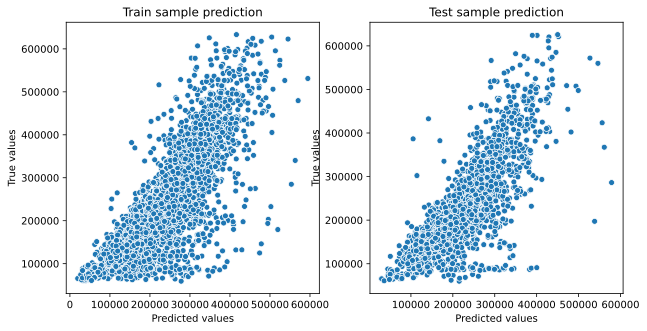

In [154]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Попробуем RFR модель

### Обучение RFR

In [155]:
%%time
rf_model = RandomForestRegressor(
    random_state=RANDOM_STATE,
    criterion='mse',
    max_depth=13,
    n_estimators=800,
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

CPU times: user 40 s, sys: 379 ms, total: 40.4 s
Wall time: 6.94 s


RandomForestRegressor(max_depth=13, n_estimators=800, n_jobs=-1,
                      random_state=45)

Train metrics
R2:	0.933
RMSE:	24072.885
MSE:	579503777.667

Test metrics
R2:	0.732
RMSE:	48104.52
MSE:	2314044883.451



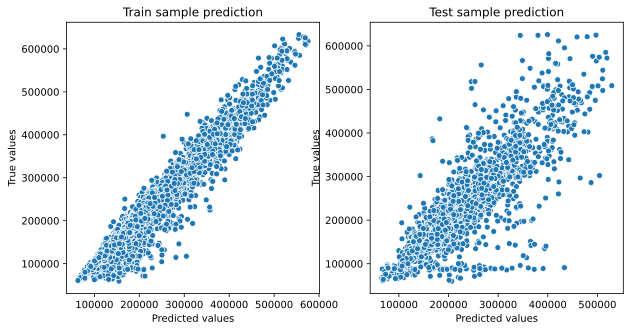

In [156]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кроссвалидация

In [157]:
cv_score = cross_val_score(
    rf_model,
    X_train,
    y_train,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
)
cv_score

exception calling callback for <Future at 0x7fce1827db80 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/dkadnikov/opt/anaconda3/lib/python3.8/site-packages/joblib/_paral

array([nan, nan, nan, nan, nan])

In [158]:
cv_score.mean()

nan

### Важность признаков

In [159]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
30       mean_district_price    0.312308
1                     Square    0.250929
2                 LifeSquare    0.202735
0                      Rooms    0.026390
5                  HouseYear    0.023511
4                 HouseFloor    0.023108
17                cat_Square    0.022191
11                  Social_3    0.020162
9                   Social_1    0.019860
12              Healthcare_1    0.018122
3                      Floor    0.016704
10                  Social_2    0.015627
29  district_sale_popularity    0.014042
6                  Ecology_1    0.012663
14                   Shops_1    0.006689
13               Helthcare_2    0.005138
27            LifeSquare_nan    0.002357
15                   Shops_2    0.001450
20             Floor_outlier    0.001418
19        LifeSquare_outlier    0.001414
28          Healthcare_1_nan    0.001322
18            Square_outlier    0.000806
8                  Ecology_3    0.000359
26          Social_3_outlier    0.000264
23         Ecology_1_outlier    0.000106
7                  Ecology_2    0.000095
25          Social_2_outlier    0.000093
24          Social_1_outlier    0.000066
16             Rooms_outlier    0.000059
22         HouseYear_outlier    0.000008
21        HouseFloor_outlier    0.000002

### Прогнозирование на тестовом ds

In [160]:
test_df

Rooms     Square  LifeSquare  Floor  HouseFloor  HouseYear  Ecology_1  \
0       1.0  36.847630   19.094182      5         9.0     1970.0   0.036122   
1       1.0  42.493907   21.617667      7        17.0     2017.0   0.072158   
2       2.0  59.463678   33.757141     19        19.0     1977.0   0.211401   
3       3.0  49.646030   33.893825      2         2.0     1965.0   0.014073   
4       1.0  53.837056   26.622109      8        17.0     1977.0   0.309479   
...     ...        ...         ...    ...         ...        ...        ...   
4995    2.0  43.177521   30.339945      5         6.0     1962.0   0.069660   
4996    3.0  93.698122   54.177570     21        27.0     2018.0   0.060753   
4997    1.0  33.656723   19.003259      2         5.0     1966.0   0.038693   
4998    1.0  38.635155   20.976257      8        14.0     1970.0   0.089040   
4999    2.0  67.122742   33.944344      9        17.0     2009.0   0.194489   

      Ecology_2  Ecology_3  Social_1  ...  HouseFloor_outlier  \
0             1          1        24  ...                   0   
1             1          1         2  ...                   0   
2             1          1         9  ...                   0   
3             1          1         2  ...                   0   
4             1          1        35  ...                   0   
...         ...        ...       ...  ...                 ...   
4995          1          1        31  ...                   0   
4996          1          1        15  ...                   0   
4997          1          1        28  ...                   0   
4998          1          1        33  ...                   0   
4999          1          1        47  ...                   0   

      HouseYear_outlier  Ecology_1_outlier  Social_1_outlier  \
0                     0                  0                 0   
1                     0                  0                 0   
2                     0                  0                 0   
3                     0                  0                 0   
4                     0                  0                 0   
...                 ...                ...               ...   
4995                  0                  0                 0   
4996                  0                  0                 0   
4997                  0                  0                 0   
4998                  0                  0                 0   
4999                  0                  0                 0   

      Social_2_outlier  Social_3_outlier  LifeSquare_nan  Healthcare_1_nan  \
0                    0                 0               0                 0   
1                    0                 0               0                 1   
2                    0                 0               1                 1   
3                    0                 0               0                 1   
4                    0                 0               1                 0   
...                ...               ...             ...               ...   
4995                 0                 0               0                 1   
4996                 0                 0               0                 0   
4997                 0                 0               0                 0   
4998                 0                 0               0                 1   
4999                 0                 0               0                 0   

      district_sale_popularity  mean_district_price  
0                         71.0        238051.584554  
1                        166.0        170490.250028  
2                        573.0        156465.396420  
3                        402.0        128211.368907  
4                         78.0        206089.520932  
...                        ...                  ...  
4995                      63.0        176218.911320  
4996                      28.0        319515.493538  
4997                      77.0        204205.468153  
4998                      38.0

In [161]:
test_df.shape

(5000, 31)

In [162]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [163]:
predictions = rf_model.predict(test_df)
predictions

array([169983.71490881, 129959.73669186, 139976.3701314 , ...,
       147510.00881495, 188276.07959605, 250076.0473244 ])

In [164]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  169983.714909
1  5925  129959.736692
2   960  139976.370131
3  3848  140174.752813
4   746  179197.995099

In [165]:
submit.to_csv('rf_submit.csv', index=False)